In [1]:
from google.colab import drive
import sys
import os

drive.mount('/content/drive')


path = '/content/drive/MyDrive/cod/LEA3_health_7'


sys.path.append(path)
os.chdir(path)

os.curdir


Mounted at /content/drive


'.'

In [2]:
import numpy as np
import joblib ### para cargar array

########Paquetes para NN #########

from sklearn import metrics ### para analizar modelo
from sklearn.ensemble import RandomForestClassifier  ### para analizar modelo
import pandas as pd

from sklearn import tree
import tensorflow as tf


import cv2 ### para leer imagenes jpeg
### pip install opencv-python

from matplotlib import pyplot as plt #

from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
x_train = joblib.load('salidas/x_train.pkl')
y_train = joblib.load('salidas/y_train.pkl')
x_test = joblib.load('salidas/x_test.pkl')
y_test = joblib.load('salidas/y_test.pkl')

In [4]:
print(x_train.shape)
print(np.prod(x_train.shape))  # total de elementos
print(5216 * 30000)            # elementos que pides en reshape

(8012, 22517)
180406204
156480000


In [5]:

################ Modelos Shallow learning ##############
########################################################

x_train.shape
x_test.shape

(2003, 22517)

In [6]:
##### validamos que sea un archivo de 1d ############
x_train[1]

array([158, 141, 157, ..., False, False, False], dtype=object)

In [ ]:

############### Indicador ################


### Recall: Tasa de identficación de positivos (de los que tenían neumonía cuantos predije tenían)
### F1_Socre: Combina Precions y recall (promedio entre dos anteriores)

### AUC: detección de positivos vs mala clasificaicón de negativos: porcentaje de los que neumonía que identifico vs los normales que digo que tiene neumonía

############Analisis problema ###########
#### me interesa recall: queremos detectar la mayor cantidad posible de casos reales de cáncer (minimizar falsos negativos). No queremos que un cáncer pase desapercibido.
#### el problema es que puede generar mucho trabajo porque clasifica a
####la mayoria como con no cancer (revisar), entonces usaremos el AUC que mide la capacidad e clasificación de cancer en balance con los que no tiene cancer, mal calsificados


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6462
           1       1.00      1.00      1.00      1550

    accuracy                           1.00      8012
   macro avg       1.00      1.00      1.00      8012
weighted avg       1.00      1.00      1.00      8012

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1599
           1       0.70      0.29      0.41       404

    accuracy                           0.83      2003
   macro avg       0.77      0.63      0.66      2003
weighted avg       0.82      0.83      0.80      2003

1.0
0.6294799039003338


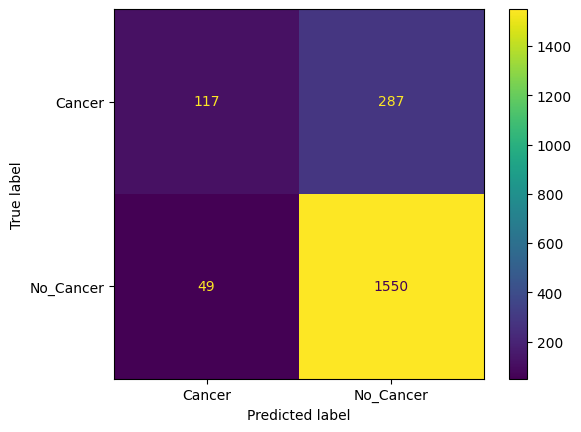

In [7]:
#################### RandomForest ##########

# Definir etiquetas para continuar

rf=RandomForestClassifier()
rf.fit(x_train, y_train)

pred_train=rf.predict(x_train)
print(metrics.classification_report(y_train, pred_train))


pred_test=rf.predict(x_test)
print(metrics.classification_report(y_test, pred_test))

print(metrics.roc_auc_score(y_train, pred_train))
print(metrics.roc_auc_score(y_test, pred_test))

cm=metrics.confusion_matrix(y_test,pred_test, labels=[1,0])
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Cancer', 'No_Cancer']) ## (Cambiar etiquetas)
disp.plot()

El modelo funciona bien detectando No_Cáncer, pero es débil detectando Cáncer, esto es peligroso en medicina, donde es más grave no detectar un cáncer (FN) que dar un falso positivo (FP).

El modelo funciona muy bien para la etiqueta de no cancer pero para la etiqueta de cancer vemos que el recall: es de un 29% lo que dice que clasifica como pacientes de cancer solo en 29% con esa etiqueta


In [8]:
########### Arbol de decisión ##########

clf_dt= tree.DecisionTreeClassifier()
clf=clf_dt.fit(x_train, y_train)

pred_train=clf_dt.predict(x_train)
print(metrics.classification_report(y_train, pred_train))
metrics.roc_auc_score(y_train, pred_train)

pred_test=clf_dt.predict(x_test)
print(metrics.classification_report(y_test, pred_test))
metrics.roc_auc_score(y_test, pred_test)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6462
           1       1.00      1.00      1.00      1550

    accuracy                           1.00      8012
   macro avg       1.00      1.00      1.00      8012
weighted avg       1.00      1.00      1.00      8012

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1599
           1       0.45      0.45      0.45       404

    accuracy                           0.78      2003
   macro avg       0.65      0.65      0.65      2003
weighted avg       0.78      0.78      0.78      2003



np.float64(0.6533538907361656)

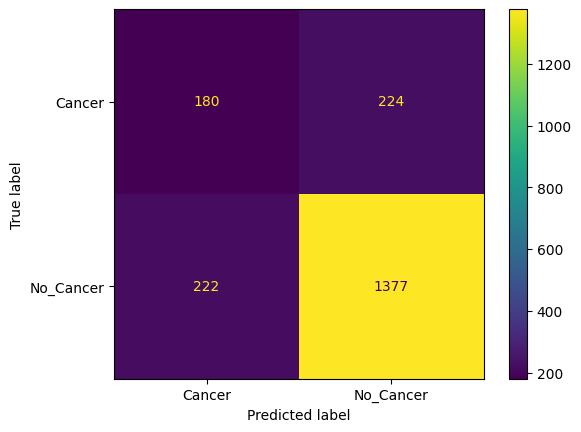

In [9]:
cm=metrics.confusion_matrix(y_test,pred_test, labels=[1,0])
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Cancer', 'No_Cancer']) ## (Cambiar etiquetas)
disp.plot()

Al utilizar el algorimto de arboles de decision se encuentra que se detectan mas casos de cancer que en el de bosques aleatorios:
 Mejoro el recall en base al modelo de random forest pero aun asi un recall de 45% es bajo para un tema tan sensible como es decir que no tiene cancer cuando realmente si lo tiene. El acurracy si redujo un poco  dado que ya no es tan bueno prediciendo los que no tienen cancer cuando no lo tienen. Ya es validar cual es el enfoque, pero optamos por uuna metrica como el recall.

In [10]:
# Transformacion de tipo para poder correr la red neuronal.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [11]:

######## Redes neuronales convencionales #########


fc_model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


checkpoint = ModelCheckpoint(
    filepath='salidas/best_model_recall.keras',
    monitor='val_Recall',        # Validar la metrica que se va a escoger de momento Recall
    mode='max',               # Usar max ya que buscamos maximizar la metrica en este punto debido a que representa un mejor resultado
    save_best_only=True,
    verbose=1
)

##### configura el optimizador y la función para optimizar ##############

fc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Recall', 'Precision'])


###### Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test), callbacks=[checkpoint])


######### Evaluar el modelo ####################
test_loss, test_acc, test_auc, test_recall, test_precision = fc_model.evaluate(x_test, y_test, verbose=2)
print("Test Recall:", test_recall)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - AUC: 0.5049 - Precision: 0.1995 - Recall: 0.2416 - accuracy: 0.6687 - loss: 556.4119
Epoch 1: val_Recall improved from -inf to 0.00000, saving model to salidas/best_model_recall.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - AUC: 0.5051 - Precision: 0.1999 - Recall: 0.2412 - accuracy: 0.6692 - loss: 551.2921 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.7983 - val_loss: 226.1793
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - AUC: 0.5556 - Precision: 0.2779 - Recall: 0.2730 - accuracy: 0.7301 - loss: 118.9928
Epoch 2: val_Recall improved from 0.00000 to 0.70297, saving model to salidas/best_model_recall.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - AUC: 0.5556 - Precision: 0.2781 - Recall: 0.2732 - accuracy: 0.7301 - loss: 118.9450 - val_AUC: 0.6936 - val_Precision: 0.3546 - val_Recall: 0.7030 - val_accuracy: 0.6820 - val_loss: 40.8121
Epoch 3/10
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/

In [12]:
best_auc=tf.keras.models.load_model('salidas/best_model_recall.keras')
test_loss, test_acc, test_auc, test_recall, test_precision = best_auc.evaluate(x_test, y_test, verbose=2)
print("Test auc:", test_auc)


63/63 - 3s - 48ms/step - AUC: 0.6936 - Precision: 0.3546 - Recall: 0.7030 - accuracy: 0.6820 - loss: 40.8121
Test auc: 0.6936312913894653


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

         0.0       0.90      0.68      0.78      1599
         1.0       0.36      0.70      0.47       404

    accuracy                           0.68      2003
   macro avg       0.63      0.69      0.62      2003
weighted avg       0.79      0.68      0.71      2003



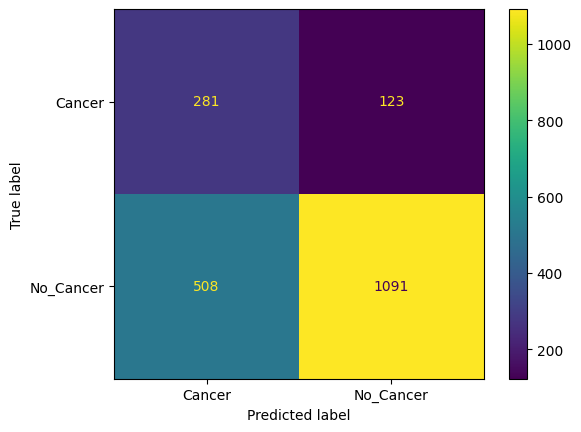

In [13]:
###### matriz de confusión test
pred_test=(best_auc.predict(x_test) > 0.9).astype('int')
cm=metrics.confusion_matrix(y_test,pred_test, labels=[1,0])
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['Cancer', 'No_Cancer']) # Validar cambiod e etiquetas
disp.plot()

print(metrics.classification_report(y_test, pred_test))


El modelo con las redes neuronales cuenta com mejor desempeño en el recall, llegando al 70%  pero a costas de no predecir tan bien como en casos anteriores los que no tienen cancer lo que llevaria a un accuracy menor que en los modelos previos. Por ello se explorara el modelo de redes neuronales convulacionales para ver el comportamiento